# CS492 Assignment #1: [ Project Title ] (Due XYZ)

## What is this?

This jupyter notebook describes the overall process of the assignment, including (1) detailed explanations about the motivation scenario along with codes and (2) skeleton codes that you are required to fill in. Two deliverables need to be submitted: this jupyter notebook and the discussion. You do not need to explicitly submit this jupyter notebook as our server keeps track of it. Make sure you submit the discussion on KLMS.

In this assignment, students are required to implement the following three functions. We are going to provide a specific algorithm for you to implement so that the task is not open-ended but concrete enough. Specific precondition and postcondition of the functions are going to be explained later.

* `getBiasScore(predictionResultTable)` : Given a prediction result that describes whether tweets are abusive depending on tweets' dialects, returns a numerical score representing the bias. 

* `undersampleData(trainingData, dialectClassifier, dialectLabel, ratio)` : Returns a dataset that undersampling has been performed. In other words, randomly select `ratio` portion of samples of tweets written in the dialect `dialectLabel` on the dataset `trainingData`. The tweets written in other dialect should remain as the original dataset. `languageClassifier` is used for predicting a dialect of tweets, which is going to be explained later.

* `processPredictionResult(predictionResult, majorLabel, minorLabel, theta)` : returns a processed prediction result in a way that it mitigates the bias. Conceptually, we are going to apply different thresholds across labels.

Please note that the objective of this assignment is not to optimize the score of bias but to experiment your own ideas around data analysis and bias mitigation, although we explicitly ask you to implement functions for the sake of assignment. Therefore, It is completely okay to revise the existing codes, and even it is highly encouraged to try things out across multiple stages of machine learning pipeline to mitigate bias. Please explore as much as you can, and write the exploration on the discussion.

Also, the dataset and overall process of this assignment has been borrowed from a set of references and tuned to present more evident results on educational purpose. Although we are dealing with the real data and existing techniques, results in this assignment do not represent the real world: we cannot directly generalize our observations in this assignment. Please focus on methodological aspects of dealing with bias. You may want to discuss limitations of the overall process of this assignment as well.

## Overall procedure of the assignment

The objective of this assignment is (1) to figure out that the model's prediction is biased with respect to dialects of tweets and (2) to mitigate such bias. To accomplish the objective, we are going to follow the procedure below.

    1. Import dataset
    
    2. Preprocess the dataset    
    
    3. Train a model             
    
    4. Evaluate the model
    
    5. Check whether the model is biased with respect to dialects
    
    6. Investigate why such bias happens
    
    7. Mitigate the bias
        
Let's go over each step!

## 1. Import dataset

We first import the dataset to train a model. We provide three datasets in total, but your tasks in this assignment are going to focus on a single dataset named `david.csv`. In other words, you don't need to perform measuring/mitigating bias on the other two datasets, although the same techniques can be applied. 

We are going to first read `david.csv` file. You can refer to [the original data](). Then we format the data to feed it to the model training stage. Here, the data formatting means that the label column name should be "class", and tweet column name should be "tweet". We are not going to use other columns.

In [24]:
import process

datasetInfo = {
    'filename': 'http://3.35.21.90:3000/bias-awareness-platform/david.csv',                         # The filename
    'label': ['Hateful', 'Offensive', 'Neither']     # Labels (0: Hateful, 1: Offensive, 2: Neither)
}

################################################################
# We also have the following two datasets. Please use these datasets for your exploration.

#datasetInfo = {
#    'filename': 'hatespeech.csv',      
#    'label': ['Normal', 'Hateful']     
#}

#datasetInfo = {
#    'filename': 'sentiment.csv',       
#    'label': ['Negative', 'Positive']  
#}
###############################################################


data = process.dataImporting(datasetInfo['filename'])    # read the dataset.
                                                         # process.py is also included in the root directory
    
formattedData = process.dataFormatting(data, datasetInfo)     # format the dataset
    
formattedData

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


## 1-1. Sample the data (Task 2)

\*\*\* **Please proceed until step 5-4 if you haven't. Then come back to this step. You can simply skip this section to understand the overall procedure** \*\*\*

To reduce the bias, we are going to sample only a part of offensive tweets written in AAE. (I'm still working here)

In [45]:
import twitteraae.code.dialectPrediction as dialectPrediction
import pandas as pd

def undersampleData(trainingData, dialectClassifier, majorAbusiveClass, majorDialectClass, ratio) :
    returnValue = trainingData
    
    # Answer
    
    dialectPrediction.load_model()
    
    def determineDialect(tweet) :
        # returns a label of the dialect prediction

        pred = dialectPrediction.predict(tweet.split())

        if pred is None :
            return 'Unknown'


        if pred[0] >= 0.5 :
            return 'AAE'
        elif pred[3] >= 0.5 :
            return 'SAE'
        else:
            return 'Unknown'

    datasetWithGroups = pd.concat([trainingData, 

                                   pd.DataFrame([ determineDialect(t) for t in trainingData['tweet'] ], columns=['dialect']

                                   )
                                  ], axis=1)
    
    datasetToUndersample = datasetWithGroups.loc[(datasetWithGroups['dialect'] == majorDialectClass) & (datasetWithGroups['class'] == majorAbusiveClass)]
    datasetToRemain = datasetWithGroups.loc[list(set(datasetWithGroups.index) - set(datasetToUndersample.index))]

    # Now we need to randomly undersample 'datasetWithMajorLabel', remaining datasetWihtoutMajorLabel
    
    datasetToUndersample = datasetToUndersample.sample(n=(int(datasetToUndersample.shape[0] * ratio)))
    
    concatenated = pd.concat([datasetToUndersample, datasetToRemain]).drop(['dialect'], axis=1)
    
    return concatenated

undersampledData = undersampleData(formattedData, dialectPrediction, 1, 'AAE', 0.5)

undersampledData

,class,tweet
3246,1,@Get__Em__Craig I hear ya hoe
23440,1,You wanna watch the game she wanna watch #scan...
14697,1,RT @ChubbyGirlGod: Lmaoo RT @patpatbush: That ...
19119,1,RT @iAMxJONES: I know where I would be tonight...
7605,1,All of my money neat all of my bitches freaky ...
...,...,...
24771,1,you look like your 12 stop talking about fucki...
24776,0,you're all niggers
24777,0,you're such a retard i hope you get type 2 dia...
24779,2,"you've gone and broke the wrong heart baby, an..."


## 2. Preprocess the dataset

The datasets need preprocessing to train a model. The methods of preprocessing can be creative and it depends on the model we choose. This assignment is going to use Logistic Regression model. To use the model, we are going to vectorize the tweet text (i.e. a text is converted into a set of numerical values, say features) so that a Logistic Regression model can be trained. To vectorize text, we are going to use [TF-IDF]() with [n-grams]() (1 $\leq$ n $\leq$ 3).

In [46]:
preprocessingResult = process.dataPreprocessing(undersampledData)

# process.dataPreprocessing returns not only a matrix that our original dataset has been converted into,
#                                   but also vectorizers, which is a function that translates a tweet into a vector.

# Detailed codes describing how to exactly preprocess the data can be found in process.py

preprocessingResult['M']    # the matrix

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/home/ubuntu/anaconda3/envs/jupyterhub_prime/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [3.88790137, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.29596712, 0.        , 0.        , ..., 3.        , 1.        ,
        0.        ],
       ...,
       [1.29596712, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [3.88790137, 3.90166915, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [2.59193425, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [47]:
preprocessingResult['M'].shape

(21008, 3915)

## 3. Train a model

Using the matrix that consists of a set of vectors, we are going to train a Logistic Regression model. We first split the matrix into two: ($X_{training}$, $y_{training}$) and ($X_{testing}$, $y_{testing}$) to train and evaluate the model where $X$ refers to a set of features and $y$ refers to the target label. During the training, we tune the model parameter to achieve better performance. We used a random grid search with 5-fold cross validation.

In [48]:
modelResult = process.buildModel(preprocessingResult)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.7s finished


## 4. Evaluate the model

Now we evaluate the model to see the performance. The result shows the model performance (precision, recall, f1-score) and the confusion matrix.

              precision    recall  f1-score   support

           0       0.35      0.39      0.37       149
           1       0.91      0.86      0.88      1525
           2       0.69      0.82      0.75       427

    accuracy                           0.81      2101
   macro avg       0.65      0.69      0.67      2101
weighted avg       0.83      0.81      0.82      2101



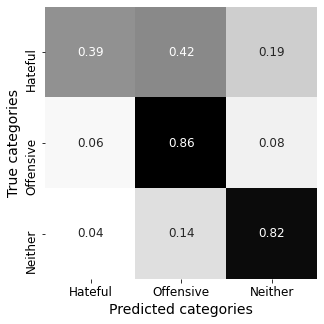

In [49]:
evaluationResult = process.evaluateModel(modelResult, datasetInfo['label'])

## 5. Check whether the model is biased with respect to dialects

Now we have a trained model, which can be used for moderating tweets. Let's check whether the model is biased with respect to dialects, African-American English and Standard American English. Here, the meaning of "our model is biased" means that __our model prediction gives different distribution across the dialects. (needs comment from you guys: do you think it is reasonable?)__. For example, if our model tends to predict a large portion of tweets in AAE as abusive whereas a large portion of tweets in SAE as neither, then we can say our model is biased (assuming the data collection method of tweet does not have any bias between AAE and SAE). 

Now we're going to use the trained model to classify a totally new tweet dataset. The data contains a label that represents the dialect. Note that we do not have the ground truth label on the tweet's abusiveness, because we don't actually know the ground truth of a tweet which we are going to apply our model. Therefore, we cannot measure any model performance (i.e. precision, recall, f1-score) with this new dataset, but we can only check the bias.

### 5-1. Import dataset

In [50]:
import pandas as pd

filepath='http://3.35.21.90:3000/bias-awareness-platform/testTweet.csv'
testTweet = pd.read_csv(filepath)      # class 0: AAE,  class 1: SSE

testTweet

,tweet,class
0,no Goodmorning text !!,0
1,Waffle House bout to grub \ud83d\ude0b\ud83d\u...,0
2,@motionlessinwim Damn straight.,0
3,Can't trust these bitches \ud83d\ude45,0
4,I still can't get over #oomf Avi's \ud83d\ude0d,0
...,...,...
1995,@Rello_Lee everybody that watched that game Wi...,1
1996,The power of the STACHE!,1
1997,It's crazy to think that you were someone's mi...,1
1998,I feel so much better about life when my hair ...,1


### 5-2. Preprocess the tweet and perform prediction with the model

We need to vectorize all the tweets and make prediction with the trained model.



In [60]:
vectorizer = preprocessingResult['vectorizer']
model = modelResult['model']

Mt = process.vectorize(vectorizer, testTweet['tweet'])

predictionResult = model.predict(Mt)
predictionProbability = model.predict_proba(Mt)

resultTable = pd.concat([testTweet, 
                         
                         pd.DataFrame(predictionResult, columns=['predLabel']), 
                         
                         pd.DataFrame({ x: [predictionProbability[i][x] for i in range(len(predictionProbability)) ] for x in range(len(predictionProbability[0])) })], 
                        
                        axis=1)

resultTable

,tweet,class,predLabel,0,1,2
0,no Goodmorning text !!,0,1,0.103642,0.631815,0.264543
1,Waffle House bout to grub \ud83d\ude0b\ud83d\u...,0,2,0.062526,0.278881,0.658594
2,@motionlessinwim Damn straight.,0,1,0.276229,0.534512,0.189259
3,Can't trust these bitches \ud83d\ude45,0,1,0.051772,0.945538,0.002690
4,I still can't get over #oomf Avi's \ud83d\ude0d,0,2,0.066876,0.360180,0.572944
...,...,...,...,...,...,...
1995,@Rello_Lee everybody that watched that game Wi...,1,2,0.072173,0.295577,0.632250
1996,The power of the STACHE!,1,1,0.100578,0.500908,0.398514
1997,It's crazy to think that you were someone's mi...,1,2,0.081651,0.332781,0.585568
1998,I feel so much better about life when my hair ...,1,2,0.365087,0.146869,0.488044


### 5-3. Post process the prediction result for mitigating bias (Task 3)

\*\*\* **Please proceed until step 7-2 if you haven't. Then come back to this step. You can simply skip this section to understand the overall procedure** \*\*\*

Now we are going to implement the bias mitigation technique called Reject Option based Classification. Given $\theta$=0.6, overwrites the assignment if the prediction result is under the critical region.

In [95]:
def rejectOptionBasedClassification(resultTable, theta, majorClass, majorLabel) :
    returnValue = resultTable
    
    ### Answer
    
    majorClassMatrix = resultTable.loc[resultTable['class'] == majorClass]
    majorPredResult = []
    
    notMajorClassMatrix = resultTable.loc[resultTable['class'] != majorClass]
    notMajorPredResult = []

    ##### for major class. i.e. AAE
    
    for (idx, line) in majorClassMatrix.iterrows() :
        target = ''
        
        labelList = [ line[x] for x in range(len(datasetInfo['label'])) ]
        
        maxProb = max(labelList)
        maxLabelIndex = labelList.index(maxProb)
        
        if max(maxProb, 1-maxProb) < theta :
            # uncertain
            if maxLabelIndex == majorLabel :
                target = labelList.index(sorted(labelList, reverse=True)[1])
            else :
                target = maxLabelIndex
        else :
            # certain
            target = maxLabelIndex
            
        majorPredResult.append(target)

    ##### for not major class. i.e. SAE
    
    for (idx, line) in notMajorClassMatrix.iterrows() :
        target = ''
        
        labelList = [ line[x] for x in range(len(datasetInfo['label'])) ]
        
        maxProb = max(labelList)
        maxLabelIndex = labelList.index(maxProb)
        
        if max(maxProb, 1-maxProb) < theta :
            #uncertain
            target = majorLabel
        else :
            # certain
            target = maxLabelIndex
            
        notMajorPredResult.append(target)

    majorClassMatrix['predLabel'] = majorPredResult
    notMajorClassMatrix['predLabel'] = notMajorPredResult

    return pd.concat([majorClassMatrix, notMajorClassMatrix])

processedResultTable = rejectOptionBasedClassification(resultTable, 0.52, 0, 1)

processedResultTable

/home/ubuntu/anaconda3/envs/jupyterhub_prime/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/jupyterhub_prime/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,tweet,class,predLabel,0,1,2
0,no Goodmorning text !!,0,1,0.103642,0.631815,0.264543
1,Waffle House bout to grub \ud83d\ude0b\ud83d\u...,0,2,0.062526,0.278881,0.658594
2,@motionlessinwim Damn straight.,0,1,0.276229,0.534512,0.189259
3,Can't trust these bitches \ud83d\ude45,0,1,0.051772,0.945538,0.002690
4,I still can't get over #oomf Avi's \ud83d\ude0d,0,2,0.066876,0.360180,0.572944
...,...,...,...,...,...,...
1995,@Rello_Lee everybody that watched that game Wi...,1,2,0.072173,0.295577,0.632250
1996,The power of the STACHE!,1,1,0.100578,0.500908,0.398514
1997,It's crazy to think that you were someone's mi...,1,2,0.081651,0.332781,0.585568
1998,I feel so much better about life when my hair ...,1,1,0.365087,0.146869,0.488044


### 5-4. Measure the score of bias (Task 1)

Given the column `class` (that represents the tweet is written in AAE or SAE) and the column `predLabel` (that represents whether the tweet is abusive), we can measure whether model's prediction is biased. There can be multiple ways to compute such bias, and each measure might captures different perspectives on the bias. 

One of the simple measures of bias is to compare the ratio of predicted labels. In other words, we can compute how much percent each predicted label account for between AAE class and SAE class, and compare the values. For example, let's say our model predicted 1000 AAE tweets and 300 of them were predicted as 'offensive'. The the 'offensive' label account for 30% of the entire prediction (let's say $P(t = 1|AAE) = 0.35$). We do the same calculating for SAE tweets, and we got 100 'offensive' tweets (let's say $P(t = 1|SAE) = 0.12$). In this case, we can say the model is likely to predict AAE tweets more offensive than SAE tweets. Let's see how it goes.

Your task is to implement the following function `getBiasScore(predictionResultTable` that computes the ratio between the portion of a label in AAE and that of SAE. i.e. <font size="5"> $\frac{ P(t=c_i|AAE) }{P(t=c_i|SAE)}$ </font> where $t$ refers to tweets and $c_i$ refers to a label representing abusiveness. Then we can get a value for each label.

       label  p_AAE  p_SAE     ratio
0    Hateful    113     40  2.825000
1  Offensive    466    451  1.033259
2    Neither    421    509  0.827112


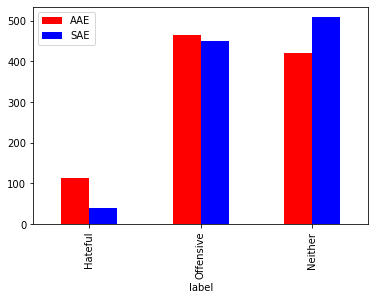

In [96]:
def getBiasScore(predictionResultTable) :
    # returns values that represent the bias for each label
    
    returnValue = pd.DataFrame([ [x, 0.1, 0.2, 0.5] for x in datasetInfo['label'] ], columns=['label', 'p_AAE', 'p_SAE', 'ratio'])

    # Answer
    
    returnValue = pd.DataFrame([ [datasetInfo['label'][x], val1, val2, val1/val2] for (x, val1, val2) in 
                                
                                zip(
                                    [ x for x in range(len(datasetInfo['label'])) ],
                                    [ predictionResultTable.loc[(resultTable['class']==0) & (predictionResultTable['predLabel']==x)].shape[0] for x in range(len(datasetInfo['label'])) ],
                                    [ predictionResultTable.loc[(resultTable['class']==1) & (predictionResultTable['predLabel']==x)].shape[0] for x in range(len(datasetInfo['label'])) ]
                                )
                               ]
                              
                              , columns=['label', 'p_AAE', 'p_SAE', 'ratio'])
    
    return returnValue

biasScore = getBiasScore(processedResultTable)

print(biasScore)

# Please refer to the structure of the table shown below. You must meet the structure. 
# Here, p_SAE means the proportion of tweets written in SAE with a label L. 
# The sum of (p_SAE_Hateful, p_SAE_Offensive, p_SAE_Neither) should be 1. Same for p_AAE.
# The ratio means p_AAE / p_SAE

# The following code is to plot a bar graph that shows the result more effectively.

AAE_statistics = processedResultTable.loc[processedResultTable['class'] == 0]['predLabel'].value_counts()
SAE_statistics = processedResultTable.loc[processedResultTable['class'] == 1]['predLabel'].value_counts()

df = pd.DataFrame([ [datasetInfo['label'][x], biasScore['p_AAE'][x], biasScore['p_SAE'][x]] for x in range(len(datasetInfo['label'])) ], 
                  
                  columns=['label', 'AAE', 'SAE'])

df.plot(kind='bar', x='label', color=['red', 'blue'], width=0.5, position=0.5)

You can figure out that our trained model actually predicts tweets written AAE more hateful and offensive than that of SAE. Then our next question should be the following :

* Why does our model have such bias even our training data doesn't have any column on dialects (i.e. whether the tweet is AAE or SAE)?
* How to mitigate such bias?

We are going to answer these questions.


## 6. Investigate why such bias happens

You can see that the distribution of AAE is highly skewed to the label 'offensive' compared to that of SAE. One of the potential reasons might be that our training dataset is biased. In other words, it could be possible that the training data contains much more AAE tweets with 'offensive' label compared to other labels ('hateful', 'neither').

To see if that's the case, we are going to go back to the training dataset and decompose the dataset into two groups: group of AAE tweets and group of SAE groups. Then we are going to plot the label distribution again.

As we had no ground truth around whether tweets are written in AAE and SAE, we are going to use a classifier that predicts such dialect. The details are written in [this paper](), and we are going to use the existing code, `dialectPrediction.py`.

`dialectPrediction.predict(str.split())` returns four values each of which refers to a probability of being a single dialect, which are African-American, Hispanic, Asian, and White, respectively. We are going to classify a tweet as AAE if the probability of being AA is greater than or equal to $0.5$. Simiarly, we classify a tweet as SAE if that of being White is greater than or equal to $0.5$. Please note that a similar approach of predicting dialects has been taken by [this research]().

The following is an example of performing dialect prediction.

In [97]:
import twitteraae.code.dialectPrediction as dialectPrediction

dialectPrediction.load_model()
pred = dialectPrediction.predict(u"hello there".split())

pred
# if pred[0] >= 0.5, then we classify the tweet as AAE
# if pred[3] >= 0.5, then we classify the tweet as SAE

array([0.16603718, 0.27450171, 0.22886004, 0.33060107])

### 6-1. Decompose the original dataset into AAE and SAE groups

In this step, we are going to group the original dataset, which we have used to train a model, into AAE and SAE groups using `dialectPrediction`. We are going to add a new column called `dialect` which consists of AAE, SAE, and Unknown.

In [98]:

originalDataset = formattedData

def determineDialect(tweet) :
    # returns a label of the dialect prediction
    
    pred = dialectPrediction.predict(tweet.split())
    
    if pred is None :
        return 'Unknown'
    
    
    if pred[0] >= 0.5 :
        return 'AAE'
    elif pred[3] >= 0.5 :
        return 'SAE'
    else:
        return 'Unknown'
    
datasetWithGroups = pd.concat([originalDataset, 
                               
                               pd.DataFrame([ determineDialect(t) for t in formattedData['tweet'] ], columns=['dialect']
                               
                               )
                              ], axis=1)

datasetWithGroups

,class,tweet,dialect
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,Unknown
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,AAE
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Unknown
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Unknown
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,AAE
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,AAE
24779,2,"you've gone and broke the wrong heart baby, an...",SAE
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,AAE
24781,1,youu got wild bitches tellin you lies,AAE


Now let's see how the distribution of `class`, a label of abusive language, with respect to `dialect`.

Total number of SAE tweets: 3534
Total number of AAE tweets: 8099
The ratio between the number of samples: 2.2917374080362194


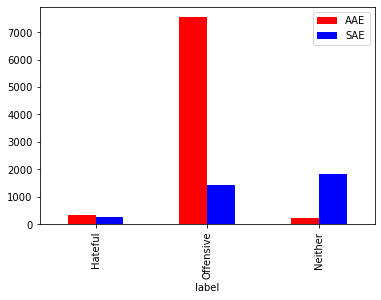

In [99]:
SAE_dist = datasetWithGroups.loc[datasetWithGroups['dialect'] == 'SAE']['class'].value_counts()
AAE_dist = datasetWithGroups.loc[datasetWithGroups['dialect'] == 'AAE']['class'].value_counts()

df = pd.DataFrame([ [datasetInfo['label'][x], AAE_dist[x], SAE_dist[x]] for x in range(len(datasetInfo['label'])) ], 
                  
                  columns=['label', 'AAE', 'SAE'])

df.plot(kind='bar', x='label', color=['red', 'blue'], width=0.5, position=0.5)

print("Total number of SAE tweets: {}".format(sum(SAE_dist)))
print("Total number of AAE tweets: {}".format(sum(AAE_dist)))

print("The ratio between the number of samples: {}".format((sum(AAE_dist)/sum(SAE_dist))))

Above graph shows that (1) the distribution of tweets in the training data is highly skewed to the 'Offensive' label for AAE group and (2) the number of samples of AAE tweets (8099) are 2.3x greater than that of SAE tweets. It motivates us to [undersample]() the AAE tweets with 'Offensive' labels. The portion of undersampling can be varied, but we are going to sample only 50% of AAE tweets with 'Offensive' label.

## 7. Mitigate the bias

With such observation, we are going to mitigate the bias (i.e. we are going to reduce the bias score that we have computed by `getBiasScore`. 

### 7-1. Undersampling

Now, **please go to the step 1-1 to implement the undersampling. After implementing the undersampling, make sure you execute all the process so far again. Then go to the next step.** The next step computes the same distribution as above, but with undersampled dataset.


Total number of SAE tweets: 3534
Total number of AAE tweets: 4324
The ratio between the number of samples: 1.22354272778721


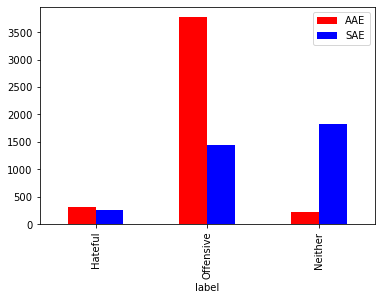

In [100]:
originalDataset = undersampledData

datasetWithGroups = pd.concat([originalDataset, 
                               
                               pd.DataFrame([ determineDialect(t) for t in formattedData['tweet'] ], columns=['dialect']
                               
                               )
                              ], axis=1)

SAE_dist = datasetWithGroups.loc[datasetWithGroups['dialect'] == 'SAE']['class'].value_counts()
AAE_dist = datasetWithGroups.loc[datasetWithGroups['dialect'] == 'AAE']['class'].value_counts()

df = pd.DataFrame([ [datasetInfo['label'][x], AAE_dist[x], SAE_dist[x]] for x in range(len(datasetInfo['label'])) ], 
                  
                  columns=['label', 'AAE', 'SAE'])

df.plot(kind='bar', x='label', color=['red', 'blue'], width=0.5, position=0.5)

print("Total number of SAE tweets: {}".format(sum(SAE_dist)))
print("Total number of AAE tweets: {}".format(sum(AAE_dist)))

print("The ratio between the number of samples: {}".format((sum(AAE_dist)/sum(SAE_dist))))

We can see that (1) the distribution of AAE tweets becomes less skewed to 'Offensive' label comapred to original dataset and (2) the ratio between the number of AAE tweets and SAE tweets has been reduced. The following is the measure of bias with the undersampled dataset: 

       label  p_AAE  p_SAE     ratio
0    Hateful    113     40  2.825000
1  Offensive    466    451  1.033259
2    Neither    421    509  0.827112


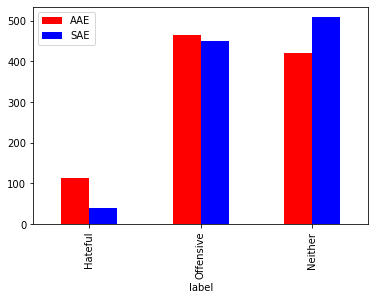

In [101]:
### the same code with above

biasScore = getBiasScore(processedResultTable)

print(biasScore)

# Please refer to the structure of the table shown below. You must meet the structure. 
# Here, p_SAE means the proportion of tweets written in SAE with a label L. 
# The sum of (p_SAE_Hateful, p_SAE_Offensive, p_SAE_Neither) should be 1. Same for p_AAE.
# The ratio means p_AAE / p_SAE

# The following code is to plot a bar graph that shows the result more effectively.

AAE_statistics = processedResultTable.loc[processedResultTable['class'] == 0]['predLabel'].value_counts()
SAE_statistics = processedResultTable.loc[processedResultTable['class'] == 1]['predLabel'].value_counts()

df = pd.DataFrame([ [datasetInfo['label'][x], biasScore['p_AAE'][x], biasScore['p_SAE'][x]] for x in range(len(datasetInfo['label'])) ], 
                  
                  columns=['label', 'AAE', 'SAE'])

df.plot(kind='bar', x='label', color=['red', 'blue'], width=0.5, position=0.5)

You can see that the ratio of "Offensive" label has been reduced (originally it was **<font color='red'> XYZ </font>**). Therefore, we can say that our model yields less biased prediction with respect to the "Offensive" label. However, you can observe that the ratio of "Hateful" label has been increased (originally it was **<font color='red'>XYZ</font>**). You may want to discuss this observation in the discussion.

### 7-2. Reject Option based Classification [cite]

In this step, we are going to implement Reject Option based Classification [cite], which is another technique of mitigating bias. This technique can be applied when model produces probabilities for prediction.

Let's say we trained a model, and use it to predict the abusive label of a tweet $t$. Then the model produces a probability for each label $l_i$, meaning the probability of being assigned to the label $l_i$ for the tweet $t$. Normally, we find the maximum probability across the labels and assign the label as a prediction result.

The insight of this bias mitigation technique is that even if we assign the label with the highest probability, it can be still uncertain. For example, let's say we have two labels $l_1$ and $l_2$, and our model produces probabilities $p_1$=0.55 and $p_2$=0.45 for a tweet $t$. Even if we can assign the label $l_1$ in this case, we can say the model is not really sure about the assignment because the probability (i.e. $p_1$) is relatively low.

The technique introduces $\theta$, a threshold to <i>defer</i> the label assignment. If $max(P(t=c_i), 1-P(t=c_i)) < \theta$ where $0.5 < \theta < 1$, we defer the assignment at the moment, meaning we do not always assign the label with the highest probability. We refer to such region as <i> critical region </i>. 

For all the deferred assignment, we assign a label in a way that it mitigates the bias. For example, in our case, if the model is not sure (i.e. the condition for deffering the decision has been satisfied) for an AAE tweet, we do not assign "Offensive" even the probability of being "Offensive" is the highest. In the case where "Offensive" is the highest, we simply assign the label with second highest probability. For the deffered assignment for a SAE tweet, we assign "Offensive" regardless of the probabilities. By having different assignment methods for different groups, we can reduce the bias.

The mathematical interpretation of the mitigation method is to give different costs when misprediction happens. For example, let's say our model predicted a label for an AAE tweet. If we have large $\theta$ in this case, it means we are highly likely to defer the assignment. In other words, we are going to give the "Offensive" label to the AAE tweet only when we are very certain. Therefore, we can interpret it in a way that the cost of misprediction becomes high especially for the case where the ground truth was not "Offensive" but our prediction is "Offensive". Note that it is relatively okay to mispredict an AAE tweet with the ground truth "Offensive" because we need to reduce the number of "Offensive" judges to mitigate bias. These two different misprediction have different costs. More detailed mathematical formulation can be found in [this paper]().

We are going to use $\theta=0.52$ in this assignment. You may want to experiment different values of $\theta$. Please go to the step 5-3. 

Now, let's compute the bias score again.

       label  p_AAE  p_SAE     ratio
0    Hateful    113     40  2.825000
1  Offensive    466    451  1.033259
2    Neither    421    509  0.827112


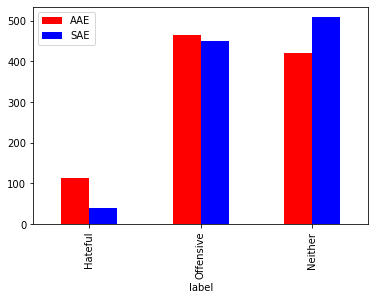

In [102]:
### the same code with above

biasScore = getBiasScore(processedResultTable)

print(biasScore)

# Please refer to the structure of the table shown below. You must meet the structure. 
# Here, p_SAE means the proportion of tweets written in SAE with a label L. 
# The sum of (p_SAE_Hateful, p_SAE_Offensive, p_SAE_Neither) should be 1. Same for p_AAE.
# The ratio means p_AAE / p_SAE

# The following code is to plot a bar graph that shows the result more effectively.

AAE_statistics = processedResultTable.loc[processedResultTable['class'] == 0]['predLabel'].value_counts()
SAE_statistics = processedResultTable.loc[processedResultTable['class'] == 1]['predLabel'].value_counts()

df = pd.DataFrame([ [datasetInfo['label'][x], biasScore['p_AAE'][x], biasScore['p_SAE'][x]] for x in range(len(datasetInfo['label'])) ], 
                  
                  columns=['label', 'AAE', 'SAE'])

df.plot(kind='bar', x='label', color=['red', 'blue'], width=0.5, position=0.5)